### Recap from previous Lab

* We "closed the loop" on our first MultiLayer Perceptron (MLP), exploring how the training routine is implemented in PyTorch (PT):

    * we saw how to use built-in loss functions in PT and we learned how to construct custom losses based upon tensor methods
    * moreover, we also saw how to use vanilla Stochastic Gradient Descent (SGD) in conjunction with backpropagation to enable the parameters updating in our MLP

### Agenda for today

* The main topic of our lecture is **regularization**
* First of all, though, we will implement a framework for monitoring the parameters during training (the so called *trajectory*), a simple research exercize
* On to regularization, we will see how to utilize various way to infuse regularization into our MLP training, still with an eye on the trajectory:

  * L2 regularization (aka *weight decay*)
  * dropout
  * regularization layers
  

### Examining parameters mid-training – the trajectory

We already covered how to save the "snapshot" of the parameters via the `state_dict` during the previous Lab.
We can use the same method to recover the trajectory during our training.

In [1]:
import torch
import os
from torch import nn
from matplotlib import pyplot as plt


from scripts import mnist
from scripts.train_utils import accuracy, AverageMeter

Let us quickly recover the stuff we implemented during Lab 2

In [2]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.flat = nn.Flatten()
        self.h1 = nn.Linear(28*28, 16)
        self.h2 = nn.Linear(16, 32)
        self.h3 = nn.Linear(32, 24)
        self.out = nn.Linear(24, 10)
    
    def forward(self, X, activ_hidden=nn.functional.relu):
        out = self.flat(X)
        out = activ_hidden(self.h1(out))
        out = activ_hidden(self.h2(out))
        out = activ_hidden(self.h3(out))
        out = self.out(out)
        return out

In [55]:
def train_epoch(model, dataloader, loss_fn, optimizer, loss_meter, performance_meter, performance, trajectory): # note: I've added a generic performance to replace accuracy
    for X, y in dataloader:
        # 1. reset the gradients previously accumulated by the optimizer
        #    this will avoid re-using gradients from previous loops
        optimizer.zero_grad() 
        # 2. get the predictions from the current state of the model
        #    this is the forward pass
        y_hat = model(X)
        # 3. calculate the loss on the current mini-batch
        loss = loss_fn(y_hat, y)
        # 4. execute the backward pass given the current loss
        loss.backward()
        # 5. update the value of the params
        optimizer.step()
        # 6. calculate the accuracy for this mini-batch
        acc = performance(y_hat, y)
        # 7. update the loss and accuracy AverageMeter
        loss_meter.update(val=loss.item(), n=X.shape[0])
        performance_meter.update(val=acc, n=X.shape[0])

        if trajectory is not None:
            trajectory.append({k: v.clone() for k, v in model.state_dict().items()})

def train_model(model, dataloader, loss_fn, optimizer, num_epochs, checkpoint_loc=None, checkpoint_name="checkpoint.pt", performance=accuracy, trajectory=None): # note: I've added a generic performance to replace accuracy and a list where to store the trajectory
    # check that trajectory is a list (or None)
    assert trajectory is None or isinstance(trajectory, list), f"The trajectory must be a list or None. Found {type(trajectory)}"

    # create the folder for the checkpoints (if it's not None)
    if checkpoint_loc is not None:
        os.makedirs(checkpoint_loc, exist_ok=True)
    
    model.train()

    # epoch loop
    for epoch in range(num_epochs):
        loss_meter = AverageMeter()
        performance_meter = AverageMeter()

        train_epoch(model, dataloader, loss_fn, optimizer, loss_meter, performance_meter, performance, trajectory)

        print(f"Epoch {epoch+1} completed. Loss - total: {loss_meter.sum} - average: {loss_meter.avg}; Performance: {performance_meter.avg}")

        # produce checkpoint dictionary -- but only if the name and folder of the checkpoint are not None
        if checkpoint_name is not None and checkpoint_loc is not None:
            checkpoint_dict = {
                "parameters": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "epoch": epoch
            }
            torch.save(checkpoint_dict, os.path.join(checkpoint_loc, checkpoint_name))
        
        # append the current params to the trajectory
        # if trajectory is not None:
        #     current_state_dict = {k: v.clone() for k, v in model.state_dict().items()} # comment on this line - why that and not `model.state_dict()`
        #     trajectory.append(current_state_dict)
    
    return loss_meter.sum, performance_meter.avg, trajectory

def test_model(model, dataloader, performance=accuracy, loss_fn=None):
    # create an AverageMeter for the loss if passed
    if loss_fn is not None:
        loss_meter = AverageMeter()
    
    performance_meter = AverageMeter()

    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            y_hat = model(X)
            loss = loss_fn(y_hat, y) if loss_fn is not None else None
            acc = performance(y_hat, y)
            if loss_fn is not None:
                loss_meter.update(loss.item(), X.shape[0])
            performance_meter.update(acc, X.shape[0])
    # get final performances
    fin_loss = loss_meter.sum if loss_fn is not None else None
    fin_perf = performance_meter.avg
    print(f"TESTING - loss {fin_loss if fin_loss is not None else '--'} - performance {fin_perf}")
    return fin_loss, fin_perf

In [56]:
minibatch_size_train = 256
minibatch_size_test = 512

trainloader, testloader, trainset, testset = mnist.get_data(batch_size_train=minibatch_size_test, batch_size_test=minibatch_size_test)

In [58]:
learn_rate = 0.1
num_epochs = 5

model = MLP()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learn_rate)

trajectory = [model.state_dict()] # we want to store the trajectory at initialization as well

In [59]:
# model, dataloader, loss_fn, optimizer, num_epochs, checkpoint_loc=None, checkpoint_name="checkpoint.pt", performance=accuracy, trajectory=None
train_loss, train_acc, trajectory = train_model(model, trainloader, loss_fn, optimizer, num_epochs, trajectory=trajectory)

Epoch 1 completed. Loss - total: 86637.1042842865 - average: 1.4439517380714417; Performance: 0.5109666666666667
Epoch 2 completed. Loss - total: 25527.31562423706 - average: 0.425455260403951; Performance: 0.8699
Epoch 3 completed. Loss - total: 18809.755084991455 - average: 0.31349591808319094; Performance: 0.9059833333015442
Epoch 4 completed. Loss - total: 15841.362720489502 - average: 0.26402271200815836; Performance: 0.9212333333651225
Epoch 5 completed. Loss - total: 14081.582968235016 - average: 0.2346930494705836; Performance: 0.9297500000317891


Let us examine the trajectory to see how parameters are encoded

In [15]:
print("--Trajectory--")
print("Length:", len(trajectory))
print("Name of parameters:", list(trajectory[0].keys()))
print("Shapes of parameters tensors")
# we loop through a state_dict as a dictionary:
for i, (param_name, params) in enumerate(trajectory[0].items()):
    print(f"  {i+1}:", param_name, "\t", params.shape)

--Trajectory--
Length: 5
Name of parameters: ['h1.weight', 'h1.bias', 'h2.weight', 'h2.bias', 'h3.weight', 'h3.bias', 'out.weight', 'out.bias']
Shapes of parameters tensors
  1: h1.weight 	 torch.Size([16, 784])
  2: h1.bias 	 torch.Size([16])
  3: h2.weight 	 torch.Size([32, 16])
  4: h2.bias 	 torch.Size([32])
  5: h3.weight 	 torch.Size([24, 32])
  6: h3.bias 	 torch.Size([24])
  7: out.weight 	 torch.Size([10, 24])
  8: out.bias 	 torch.Size([10])


As a first step towards examining the trajectory, we might wanna calculate the norm of the parameters.

First we may want to gather all of the parameters inside a single structure. We hence define a function which lets us do so

In [33]:
def flatten_parameters(state_dict):
    # this gives us the number of parameters per layer
    params_num_per_layer = [struct.numel() for struct in state_dict.values()]
    # by summing the list, we get the total no. of parameters
    params_num = sum(params_num_per_layer)
    # we create a tensor to host all of these parameters
    params_tensor = torch.empty([params_num])
    # we populate the tensor
    num_params_inserted = 0
    for struct in state_dict.values():
        params_tensor[num_params_inserted : num_params_inserted + struct.numel()] = struct.flatten()
        num_params_inserted += struct.numel()
    
    return params_tensor

We execute for each trajectory

In [53]:
trajectories_flattened = [flatten_parameters(t) for t in trajectory]

Now we can calculate the norms and plot them to try and find regularities

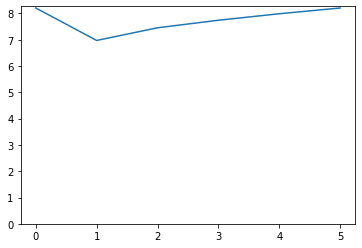

In [54]:
trajectories_norms = [f.norm() for f in trajectories_flattened]
plt.plot(trajectories_norms)
plt.ylim(0)
plt.show()